In [1]:
%%capture
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
! pip install numpy
! pip install matplotlib

In [2]:
import gzip
import requests
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchmetrics import ConfusionMatrix 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

In [3]:
# CONFIG
DEVICE = 'cuda'

In [4]:
# Load in MNIST data
folder = Path('data')

urls= [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz' 
        ]

folder.mkdir(exist_ok=True)
for url in urls:
    r = requests.get(url)
    
    if (r.status_code == 200):
        open(Path(folder) / Path(str(url)).name, 'wb').write(r.content)
    else:
        print(r.status_code)
    

In [5]:
# Read data into memory
data_paths = list(Path(folder).glob('*.gz'))

data = []
for path in data_paths:
    with open(path, "rb") as f:
        temp = f.read()
        temp = np.frombuffer(gzip.decompress(temp), dtype=np.uint8).copy()
        data.append(temp)

In [6]:
# Remove magic numbers (The training set contains 60000 examples, and the test set 10000 examples.)
train_x = data[2][16:]
train_y = data[3][8:]
test_x = data[0][16:] 
test_y = data[1][8:]

# Reshape
train_x = np.array(train_x).reshape((-1,28,28))
train_y = np.array(train_y)
test_x = np.array(test_x).reshape((-1,28,28,))
test_y = np.array(test_y)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

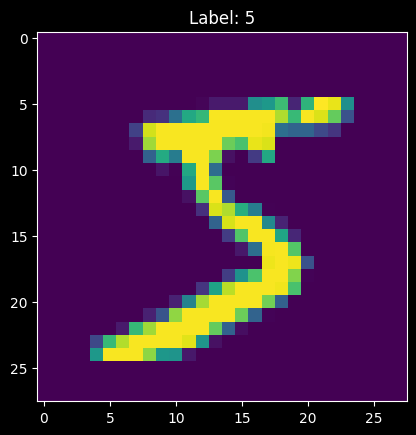

In [7]:
# Check that we have loaded data correctly
plt.style.use('dark_background')
plt.title(f'Label: {train_y[0]}')
plt.imshow(train_x[0]);

In [8]:
# Model (Just linear layers)
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.stack = nn.Sequential(
                                nn.Linear(28*28,400),
                                nn.ReLU(),
                                nn.Linear(400,100),
                                nn.ReLU(),
                                nn.Linear(100,10),
                                nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.stack(x)
        return x

model = Net().to(DEVICE)

model

Net(
  (stack): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [9]:
# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
import math   
EPOCHS = 100
BS = 1024

traning_loss = []

for epoch in range(EPOCHS):
    for batch in range(math.floor(train_y.shape[0]/BS)):

        random_sample = random.sample(range(len(train_y)), BS)
        inputs = torch.tensor(train_x[random_sample]).reshape(-1,28*28).float().to(DEVICE)
        labels = torch.tensor(train_y[random_sample]).long().to(DEVICE)

        optimizer.zero_grad() # Reset gradient to zero

        # Forward
        output = model(inputs)

        # Compute loss
        loss = criterion(output, labels)

        # Update loss
        loss.backward()

        # optimizer
        optimizer.step()

    # Current loss
    traning_loss.append(loss.item())


torch.Size([1024, 784])


NameError: name 'loss' is not defined

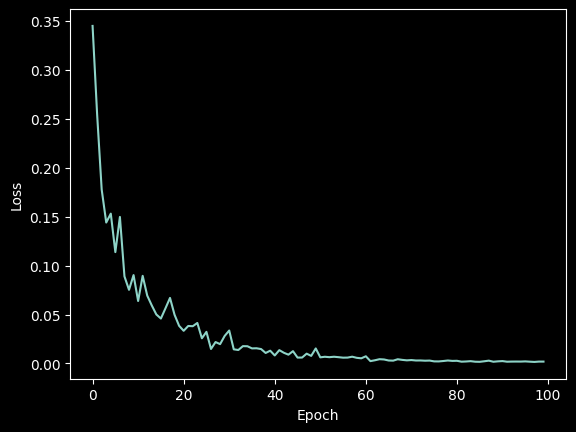

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(traning_loss);
plt.savefig('loss.png')

In [ ]:
# Test 

prediction_y, true_y = [],[]

total_correct = 0
with torch.no_grad():
    for idx, test in enumerate(test_x):
        inputs = torch.tensor(test).reshape(-1,28*28).float().to(DEVICE)
        label = torch.tensor(test_y[idx]).to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        prediction_y.append(predicted.item())
        true_y.append(label.item())
        
        total_correct += (predicted == label).sum()
    total = idx

print(f"Accuracy: {(total_correct.item() /  total):.3f}")

Accuracy: 0.975


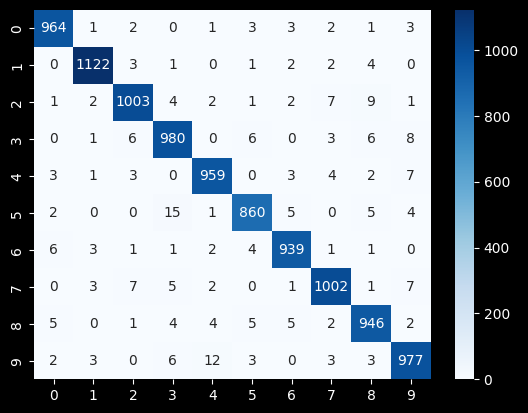

In [ ]:
# Comput confusion matrix

confmat = ConfusionMatrix(num_classes=10)
confusion_matrix = confmat(torch.tensor(prediction_y), torch.tensor(true_y))
df = pd.DataFrame(confusion_matrix)

plt.figure()
sns.heatmap(df,annot=True,cmap='Blues', fmt='g');
sns.reset_orig() # Reset back to default values
plt.savefig('confusion_matrix.png')

In [ ]:
# Load inn test image from different sources
image = Image.open('test_image.png').convert('L').resize((28, 28))
image_tensor = np.array(image)
image_tensor = torch.tensor(image_tensor).reshape(-1,28*28).float().to(DEVICE)

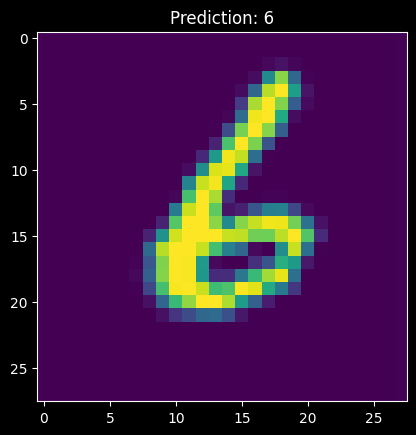

In [ ]:
# Test model on test image
model.eval()
output = model(image_tensor)
pred = torch.argmax(output, 1)
plt.title(f'Prediction: {pred.item()}')
plt.imshow(image);
plt.savefig('predicted.png')